In [135]:
from pathlib import Path
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import bz2
from scipy import stats
import matplotlib.pyplot as plt

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [2]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  bad_ids.xlsx	    products_20200901.txt
10_groups.csv  product_groups.csv   products_20201101.txt
11_groups.csv  product_groups.docx  product_sum_20201001.txt


In [3]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [35]:
g_10 = pd.read_csv('./data/10_groups.csv')
g_10.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-10-01 20:22:55,2035558,0.0,1636749,52,339,1.0,107.90,0,10004
1,2020-10-01 20:54:12,13037327,0.0,267261,52,339,1.0,80.04,0,10004
2,2020-10-01 21:25:59,1430590,0.0,1331395,61,379,1.0,31.92,1,10091
3,2020-10-01 13:31:01,3504660,0.0,641525,61,97,1.0,55.98,0,10091
4,2020-10-01 16:32:06,11024438,0.0,1325852,61,97,4.0,176.00,0,10091


In [36]:
g_11 = pd.read_csv('./data/11_groups.csv')
g_11.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-11-01 15:29:01,3121751,0.0,332351,52,271,1.0,107.98,0,10004
1,2020-11-01 12:41:10,22047017,8293317.0,1875438,52,-9999,1.0,108.00,0,10004
2,2020-11-01 13:17:09,6419825,0.0,563112,61,379,2.0,112.00,0,10091
3,2020-11-01 12:31:31,10284541,0.0,1841710,61,379,1.0,55.91,0,10091
4,2020-11-01 13:06:15,10424967,0.0,1304277,61,271,2.0,87.80,0,10091


In [4]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [4]:
bad_ids = pd.read_excel('./data/bad_ids.xlsx')
del bad_ids['Unnamed: 0']
bad_ids.head()

,id_card
0,806096
1,1438102
2,72344
3,427981
4,1528414


In [5]:
bad_set = set(bad_ids['id_card'])
g_9_filtered = g_9[~g_9['id_card'].isin(bad_set)]
g_9_filtered.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [154]:
g_9_filtered['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

We want to test if there is significant difference between orders with discounted product and without discounted products. Let H<sub>0</sub> be that there is no differnece between order sum of orders with discounted products and without.

In [6]:
disc_id_doc_set = set(g_9_filtered[g_9_filtered['is_green'] == 1]['id_doc'])

In [15]:
discount_sum_9 = g_9_filtered[g_9_filtered['id_doc'].isin(disc_id_doc_set)].groupby(by=['id_doc'])['sum'].sum()

In [9]:
discount_sum_9.head()

id_doc
19     200.0
60      54.6
76     114.6
138     93.0
152    187.6
Name: sum, dtype: float64

In [20]:
discount_sum_9.mean(), discount_sum_9.var()

(603.6524604761845, 359910.94716390467)

In [12]:
discount_sum_9.shape

(1064042,)

In [14]:
not_discount_sum_9 = g_9_filtered[~g_9_filtered['id_doc'].isin(disc_id_doc_set)].groupby(by=['id_doc'])['sum'].sum()

In [16]:
not_discount_sum_9.head()

id_doc
2      396.00
4     1597.00
5      254.00
16     709.06
18     707.00
Name: sum, dtype: float64

In [21]:
not_discount_sum_9.mean(), not_discount_sum_9.var()

(653.2083108292152, 480486.7904774185)

In [18]:
not_discount_sum_9.shape

(5840783,)

In [40]:
stats.ttest_ind(discount_sum_9, not_discount_sum_9.sample(discount_sum_9.shape[0]))

Ttest_indResult(statistic=-55.11290685538025, pvalue=0.0)

In [106]:
stats.spearmanr(discount_sum_9, not_discount_sum_9.sample(discount_sum_9.shape[0]))

SpearmanrResult(correlation=-0.0025348075480587707, pvalue=0.008930161189452567)

In [111]:
stats.pearsonr(discount_sum_9, not_discount_sum_9.sample(discount_sum_9.shape[0]))

(-0.0014731864458552475, 0.12860490264794489)

P-value is zero (or close to zero, depends on how the pd samples), this means that H<sub>0</sub> is rejected. However this may mean that orders with discount significantly higher or significantly lower. Mean of orders with discount is lower than that of without discount, this means that orders without discount have significatnly higher sum and thus it is less probable for a discounted item to be bought if the sum of the order is higher.

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [153]:
g_9_filtered['date'] = pd.to_datetime(g_9_filtered['date'],format='%Y-%m-%d %H:%M:%S')
g_9_filtered['day'] = g_9_filtered['date'].dt.day

<ipython-input-153-9be332515df3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_9_filtered['date'] = pd.to_datetime(g_9_filtered['date'],format='%Y-%m-%d %H:%M:%S')
<ipython-input-153-9be332515df3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_9_filtered['day'] = g_9_filtered['date'].dt.day


In [290]:
g_9_filtered.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,day,week
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004,1,36
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004,1,36
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004,1,36
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004,1,36
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091,1,36


In [117]:
day_count = g_9_filtered[['id_doc', 'day']].groupby('day')['id_doc'].count()
day_count

day
1     1269893
2     1285415
3     1287425
4     1270192
5     1053459
6     1158077
7     1371646
8     1227093
9     1336351
10    1305395
11    1284777
12    1087414
13    1168560
14    1370166
15    1316259
16    1326892
17    1181904
18    1429865
19    1168649
20    1206583
21    1370546
22    1352159
23    1343573
24    1336031
25    1364338
26    1130494
27    1220942
28    1415253
29    1411357
30    1415295
Name: id_doc, dtype: int64

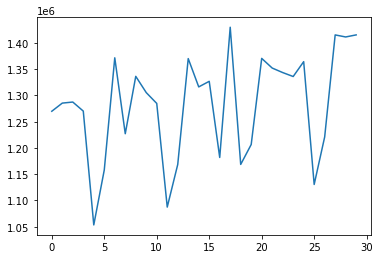

In [136]:
plt.plot(day_count)

In [129]:
day_count = list(day_count)

In [130]:
wage = day_count[:7]+day_count[20:27]
no_wage = day_count[7:20]+day_count[27:]
wage, no_wage

([1269893,
  1285415,
  1287425,
  1270192,
  1053459,
  1158077,
  1371646,
  1370546,
  1352159,
  1343573,
  1336031,
  1364338,
  1130494,
  1220942],
 [1227093,
  1336351,
  1305395,
  1284777,
  1087414,
  1168560,
  1370166,
  1316259,
  1326892,
  1181904,
  1429865,
  1168649,
  1206583,
  1415253,
  1411357,
  1415295])

In [140]:
stats.ttest_ind(wage, no_wage)

Ttest_indResult(statistic=-0.4851982460193491, pvalue=0.631310492438756)

P-value is quiter large and this may mean that there is no significant difference between wage and no wage days. 

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

## Frequent Buyers

In [155]:
g_9_filtered['week'] = g_9_filtered['date'].dt.week

<ipython-input-155-798a9899c6fd>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  g_9_filtered['week'] = g_9_filtered['date'].dt.week
<ipython-input-155-798a9899c6fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_9_filtered['week'] = g_9_filtered['date'].dt.week


In [165]:
filter_days = g_9_filtered[['day', 'id_card']].drop_duplicates()

In [157]:
filter_days.head()

,day,id_card,id_doc
0,1,1538855,1283228
1,1,267307,8873113
2,1,610220,12712899
3,1,441497,21535283
4,1,1065358,642341


In [174]:
day_count = filter_days[['day','id_card']].groupby(by='id_card')['day'].count()
day_count.head()

id_card
0    10
1     1
2     1
3     8
4     5
Name: day, dtype: int64

In [175]:
day_count.sort_values()

id_card
921851      1
549409      1
1340785     1
1340786     1
549405      1
           ..
1334945    30
1790219    30
1572850    30
6183       30
1507020    30
Name: day, Length: 1333958, dtype: int64

In [176]:
day_count[day_count>28]

id_card
5096       30
6183       30
7627       29
57303      30
58154      30
           ..
1794521    29
1804583    30
1806522    29
1824958    30
1838590    29
Name: day, Length: 163, dtype: int64

There are people that come daily or almost daily (and people that come ones a month)

In [171]:
filter_weeks = g_9_filtered[['week', 'id_card']].drop_duplicates()
filter_weeks.head()

,week,id_card
0,36,1538855
1,36,267307
2,36,610220
3,36,441497
4,36,1065358


In [172]:
week_count = filter_weeks[['week','id_card']].groupby(by='id_card')['week'].count()
week_count.head()

id_card
0    4
1    1
2    1
3    5
4    3
Name: week, dtype: int64

In [173]:
week_count.sort_values()

id_card
921851     1
894123     1
1545583    1
1545589    1
480611     1
          ..
812827     5
371521     5
1624867    5
1625203    5
1124830    5
Name: week, Length: 1333958, dtype: int64

And people that come weekly.

## Average purchase sum

In [205]:
mean = g_9_filtered.groupby(['id_doc', 'id_card']).agg(sum=('sum', 'sum'))
mean = mean.reset_index()

In [263]:
std = mean.groupby('id_card').agg(count=('id_doc', 'count'), std=('sum', 'std'))
std = std[std['count'] >= 5]
std = std.reset_index()
std.head()        

,id_card,count,std
0,0,10,217.845882
1,3,9,249.674631
2,4,5,480.021854
3,10,9,430.796019
4,11,7,415.611142


In [220]:
std[std['std'] < 100]

,id_card,count,std
8,17,6,40.386021
11,26,8,84.661933
18,47,7,90.394680
24,61,26,85.863763
30,72,16,74.427626
...,...,...,...
487721,1930076,6,62.963481
487729,1930434,6,72.831178
487737,1930788,6,34.932316
487740,1930923,5,52.089346


In [227]:
g_9_filtered[g_9_filtered['id_card'].isin(set(std[std['std'] < 20]['id_card']))].groupby(['id_card','id_doc']).agg(avg_sum=('sum','sum'))

avg_sum
id_card id_doc           
1562    3701614     133.0
        5825664     153.0
        8658181     133.0
        10519201    133.0
        10636037    133.0
...                   ...
1929862 120093       37.0
        1851311      37.0
        2856477      37.0
        8190357      42.0
        18138222     37.0

[5689 rows x 1 columns]

Here we can see that there are people that spend roughly the same amount of money.

## Orders amount

In [286]:
count = g_9_filtered.groupby(['id_card'])['id_doc'].count()

In [287]:
count

id_card
0          44
1           1
2          12
3          34
4          36
           ..
1933013     1
1933385    35
1934103    24
1939417    64
1944074    26
Name: id_doc, Length: 1333958, dtype: int64

array([[<AxesSubplot:title={'center':'id_doc'}>]], dtype=object)

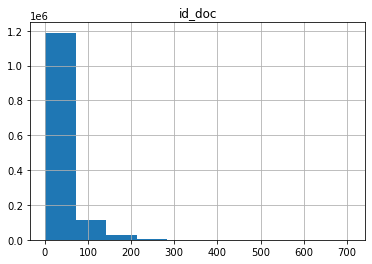

In [288]:
count.to_frame().hist()

array([[<AxesSubplot:title={'center':'id_doc'}>]], dtype=object)

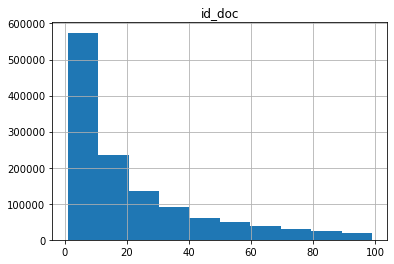

In [289]:
count[count<100].to_frame().hist()

Well we definitely can see people that go really frequently and people who visit comparatively rare.

## Usual cart 

To see which users buy the same products a lot we can see the users who have some product dominant among them. This is not as perfect and will allow us to see only one favourite item, but is still better than nothing. We can do this by finding users who have some items with higher share compared to other items

In [279]:
known = g_9_filtered[~(g_9_filtered.id_group == -9999)]
known.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group,day,week
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004,1,36
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004,1,36
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004,1,36
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004,1,36
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091,1,36


In [232]:
tov_count = known.groupby(['id_card', 'id_group', 'id_doc'])['id_tov'].count()

In [239]:
avg_tov_count = tov_count.to_frame().reset_index().groupby(['id_card', 'id_group'])['id_doc'].count()

In [259]:
tov_doc_count = g_9_filtered[['id_card', 'id_doc']].drop_duplicates().groupby('id_card').count().reset_index()
tov_doc_count['total_count'] = tov_doc_count['id_doc']
tov_doc_count = tov_doc_count.drop(columns='id_doc')
tov_doc_count = tov_doc_count[tov_doc_count.total_count >= 5]

In [260]:
avg_count = pd.merge(avg_tov_count,tov_doc_count,how="left",on='id_card').dropna()

In [261]:
avg_count['percent'] = avg_count['id_doc']/avg_count['total_count']
avg_percent= avg_count.groupby('id_card')['percent'].mean()
avg_percent[avg_percent>0.8]

id_card
7976       1.000000
10496      0.966667
12325      0.866667
15858      1.000000
22487      0.916667
             ...   
1920830    0.888889
1924114    0.904762
1926663    0.850000
1929198    0.833333
1929462    0.800000
Name: percent, Length: 1008, dtype: float64

These users buy the same product a lot.